In [1]:
import os
import numpy as np
import pandas as pd

import PIL
import glob
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedGroupKFold
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_addons as tfa

from tensorflow.keras import callbacks
import tensorflow.keras.backend as K


physical_devices = tf.config.list_physical_devices('GPU')

print("Num GPUs Available: ", len(physical_devices))

try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('setted')
except:
    pass

Num GPUs Available:  1
setted


2022-07-19 16:47:10.998009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 16:47:11.035727: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 16:47:11.036254: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [5]:
#Globals

PATH_DIR = "."
MASK_CLASS = ['large_bowel', 'small_bowel', 'stomach']
MASK_ENCODE = dict(zip(MASK_CLASS, np.arange(1,4)))

PIXEL_NORM = 65535

IMG_SIZE = (128, 128)

MASK_COL = [np.array([255,0,0,60])/255. , np.array([0,0,255,60])/255., np.array([0,255,0,60])/255.]
MASK_COL_DICT = dict(zip(MASK_CLASS, MASK_COL))


In [6]:
#Visualisation functions

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1])
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    img = img.reshape(shape)  # Needed to align to RLE direction
    
    return img


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def process_img(img_path, percentile=98):    
    """
    images are 16-bit png encoded. make sure you define the appropriate dtype when decoding
    there are light artifacts which impact the overall normalization.
    either make sure mean pixel intensity is ~consistent, or scale by 95% brightest pixel + clip
    """
    img = tf.io.decode_png(tf.io.read_file(img_path), dtype=tf.uint16)
    img = tf.cast(img, dtype=tf.float32)
    
#     img_cutoff = tfp.stats.percentile(img, 98)
    
    img = tf.math.divide_no_nan(img, tf.math.reduce_max(img))
#     img = tf.math.divide_no_nan(img, img_cutoff)
    
#     contrast = (tf.math.reduce_mean(img).numpy() - contrast_mean)/(1 - contrast_mean)
#     img = (img - contrast) / (1 - contrast)

#     contrast = tf.math.reduce_mean(img).numpy() / contrast_mean
#     img = img / contrast
    
#     img = tf.clip_by_value(img, 0., 1.)
    
    #print(tf.math.reduce_mean(img).numpy(), tf.math.reduce_min(img).numpy(), tf.math.reduce_std(img).numpy())
    return img

def plot_dataset(elem):
    """
    input is a (img, mask) tuple with a dimensions of (n, size, 1), (n, size, MASK_CLASS)
    batch size is usually a multiple of 2^N where N > 1, so they are divisible by 4
    """
    img, mask = elem
    batch_size = img.shape[0]
    
    num_cols = 4
    num_rows = batch_size // 4
    num_plots = num_cols * num_rows
    
    fig = plt.figure(figsize=(2*num_rows,8))
    plt.axis(False)

    for k in range(num_plots):
        ax = fig.add_subplot(num_rows, num_cols, k + 1)
        ax.imshow(img[k,:,:], cmap='gray')
        
        for i in range(len(MASK_CLASS)):
            ax.imshow(np.tile(mask[k,:,:,i+1][:,:,np.newaxis], 4) * MASK_COL[i])

        ax.axis(False)
        
    plt.tight_layout()
    plt.show()   
    return

def single_panel(df, caseid, day=None, slice_=0):
    
    _tmp_df = df[(df['caseid'] == caseid)]
    if day == None:
    #all days have 144 slices, so sample is aok
        day = _tmp_df['day'].sample().iloc[0]
        
    if isinstance(day, int):
        day = f'day{day}'
        
    _tmp_df = _tmp_df[_tmp_df['day'] == day]
    _tmp_df = _tmp_df[_tmp_df['slicenum'] == slice_].iloc[0]
    
    _img = process_img(_tmp_df['fn'])

    fig = plt.figure(figsize=(5,5))    
    ax = fig.add_subplot(111)
    ax = ax.hist(np.ravel(_img), bins=40)
    
    fig = plt.figure(figsize=(5,5))    
    ax = fig.add_subplot(111)
    ax.imshow(_img, cmap='gray')
    for class_ in MASK_CLASS:
        if not _tmp_df[class_] == 'nan':
            ax.imshow(np.tile(rle_decode(_tmp_df[class_], (_tmp_df['height'],_tmp_df['width']))[...,np.newaxis], 4) * MASK_COL_DICT[class_])
    ax.axis(False)
    ax.set_title(f'caseid{caseid}-{day}-{slice_}')
        
    plt.tight_layout()
    plt.show()
    
    return
    
def random_panels(df, caseid, day=None, start_slice=None):
    """
    will convert to rgb for plotting only - plot triplets of input
    """
    num_rows = 8
    num_cols = 8
    num_plots = num_rows * num_cols
    
    _tmp_df = df[(df['caseid'] == caseid)]
    
    if day == None:
        #all days have 144 slices, so sample is aok
        day = _tmp_df['day'].sample().iloc[0]
        
    if isinstance(day, int):
        day = f'day{day}'
        
    _tmp_df = _tmp_df[_tmp_df['day'] == day]
    max_slice = _tmp_df['total_slices'].iloc[0]
    
    if start_slice == None:
        start_slice = int((max_slice - num_plots) * np.random.rand())

    start_slice = min(start_slice, max_slice - num_plots)
    
    #create figure object, iterate over num_plots
    fig = plt.figure(figsize=(12,12))
    plt.title(f'caseid{caseid}-{day}-{start_slice}')
    plt.axis(False)
    
    for k in range(num_plots):
        _tmp_img = _tmp_df.iloc[start_slice + k]
        ax = fig.add_subplot(num_rows, num_cols, k + 1)
        ax.imshow(process_img(_tmp_img['fn']), cmap='gray')
        for class_ in MASK_CLASS:
            if not _tmp_img[class_] == 'nan':
                ax.imshow(np.tile(rle_decode(_tmp_img[class_], (_tmp_img['height'],_tmp_img['width']))[...,np.newaxis], 4) * MASK_COL_DICT[class_])
        ax.axis(False)
        
    plt.tight_layout()
    plt.show()
    
    return

def random_panels_same_slice(df, start_slice=None):
    """
    will convert to rgb for plotting only - plot triplets of input
    """
    num_rows = 8
    num_cols = 8
    num_plots = num_rows * num_cols
    
    _tmp_df = df[df['slicenum'] == start_slice]
    idx_pos = int((len(_tmp_df) - num_plots) * np.random.rand())
    
    #create figure object, iterate over num_plots
    fig = plt.figure(figsize=(12,12))
    plt.title(f'{start_slice}')
    plt.axis(False)
    
    for k in range(num_plots):
        _tmp_img = _tmp_df.iloc[idx_pos + k]
        ax = fig.add_subplot(num_rows, num_cols, k + 1)
        ax.imshow(process_img(_tmp_img['fn']), cmap='gray')
        for class_ in MASK_CLASS:
            if not _tmp_img[class_] == 'nan':
                ax.imshow(np.tile(rle_decode(_tmp_img[class_], (_tmp_img['height'],_tmp_img['width']))[...,np.newaxis], 4) * MASK_COL_DICT[class_])
        ax.axis(False)
        
    plt.tight_layout()
    plt.show()
    
    return


In [7]:
def df_preprocessing(df, train_glob):
    """
    create processed dataframe from train.csv
    
    tf pipeline taking in to_dict does not like mixed classes inside columns. segmentation column contains NaN and strings, convert NaN to string
    
    """
    #unstack the class into columns. n_seg will let you know how many classes are present.
    df = df.fillna({'segmentation':'nan'})
    df = df.set_index(['id', 'class'])['segmentation'].unstack().reset_index()
    df['n_seg'] = (~(df.loc[:,['large_bowel', 'small_bowel', 'stomach']] == 'nan')).sum(axis=1)
    
    df['caseid'] = df['id'].apply(lambda x: int(x.split('_')[0].replace('case', '')))
    df['day'] = df['id'].apply(lambda x: x.split('_')[1])
    df['slicenum'] = df['id'].apply(lambda x: int(x.split('_')[-1]))

    #use glob to get filepaths of images, and merge the paths into the original dataframe. isolate slice metadata into columns
    _glob_df = pd.DataFrame(train_glob, columns=['fn'])
    _glob_df['caseid'] = _glob_df['fn'].apply(lambda x: int(x.rsplit('/', 4)[1].replace('case', '')))
    _glob_df['day'] = _glob_df['fn'].apply(lambda x: x.rsplit('/', 4)[2].split('_')[1])
    _glob_df['slicenum'] = _glob_df['fn'].apply(lambda x: int(x.rsplit('/', 4)[-1].split('_')[1]))
    
    #WIDTH AND HEIGHT ARE MIXED UP.
    _glob_df['width'] = _glob_df['fn'].apply(lambda x: int(x.rsplit('/', 4)[-1].split('_')[2]))
    _glob_df['height'] = _glob_df['fn'].apply(lambda x: int(x.rsplit('/', 4)[-1].split('_')[3]))
    _glob_df['h_spacing'] = _glob_df['fn'].apply(lambda x: float(x.rsplit('/', 4)[-1].split('_')[4]))
    _glob_df['w_spacing'] = _glob_df['fn'].apply(lambda x: float(x.rsplit('/', 4)[-1].split('_')[5].rsplit('.',1)[0]))
    
    _glob_df['total_slices'] = _glob_df.groupby(['caseid', 'day'])['slicenum'].transform(len)
    
    df = df.merge(_glob_df, on=['caseid', 'day', 'slicenum'])
    
    #reorder
    column_order = ["id", "fn", "n_seg",
                    "large_bowel", "small_bowel", "stomach",
                    "height", "width", "h_spacing", 
                    "w_spacing", "caseid", "day", 
                    "total_slices", "slicenum",]
    
    #remove faulty cases
    df[~df['id'].str.contains('case7_day0') & ~df['id'].str.contains('case81_day30')].reset_index()
    
    return df[column_order]

train_df = pd.read_csv(f"{PATH_DIR}/train.csv")
train_fp = glob.glob(f'{PATH_DIR}/train/**/*.png', recursive=True)

train_df = df_preprocessing(train_df, train_fp)

train_df.head()

,id,fn,n_seg,large_bowel,small_bowel,stomach,height,width,h_spacing,w_spacing,caseid,day,total_slices,slicenum
0,case101_day20_slice_0001,./train/case101/case101_day20/scans/slice_0001...,0,nan,nan,nan,266,266,1.5,1.5,101,day20,144,1
1,case101_day20_slice_0002,./train/case101/case101_day20/scans/slice_0002...,0,nan,nan,nan,266,266,1.5,1.5,101,day20,144,2
2,case101_day20_slice_0003,./train/case101/case101_day20/scans/slice_0003...,0,nan,nan,nan,266,266,1.5,1.5,101,day20,144,3
3,case101_day20_slice_0004,./train/case101/case101_day20/scans/slice_0004...,0,nan,nan,nan,266,266,1.5,1.5,101,day20,144,4
4,case101_day20_slice_0005,./train/case101/case101_day20/scans/slice_0005...,0,nan,nan,nan,266,266,1.5,1.5,101,day20,144,5


In [8]:
"""
Augmentations

After some EDA, the position of the bodies on the image can be translated and possibily rotated up to a few degrees.
Color contrast could be minorly adjusted, maybe by changing the percentile pixel from 98% to 97-99%
Finally, small zooms could be implemented.

MRI's feet first-head first or both? This will tell us if we need to apply left/right flips.

THESE AUGMENTATIONS SHOULD BE APPLIED IN A (1,x,y,SET)


Train first without any augmentation, then add augmentation later
"""

def fixup_shape(images, labels):
    """
    fixes shape to be via crop/pad 272 x 272, use as final
    """
    width = IMG_SIZE[0]
    height = IMG_SIZE[1]
    
#     img = tf.clip_by_value(img, 0., 1.)
    
    #return tf.image.resize_with_crop_or_pad(images, width, height), tf.image.resize_with_crop_or_pad(labels, width, height)
    return tf.image.resize_with_pad(images, width, height, method='nearest'), tf.image.resize_with_pad(labels, width, height, method='nearest')
    
def random_zoom(img, label, p=0.75):
    """
    random zoom between 0-10%. to achieve this, 
    then apply a standard resize to 272, 272 using bilinear + nearest neighbour interpolation.
    preserve aspect ratio
    """
    if tf.random.uniform([]) > p: return img, label
    
    w = img.shape[1]
    w = tf.cast(w * tf.random.uniform([], 0.95, 1.05), dtype=tf.int32)
    
    return tf.image.resize_with_pad(img, w, w), tf.image.resize_with_pad(label, w, w, method='nearest')

def random_rotate(img, label, p=0.75):
    """
    0-2.5 degrees (0 - pi/72 degrees)
    """
    if tf.random.uniform([]) > p: return img, label
    
    angle = tf.random.uniform([], -np.pi/18, np.pi/18)
    
    return tfa.image.rotate(img, angle), tfa.image.rotate(label, angle)

def random_shift(img, label, p=0.75):
    """
    random translation of image, towards the center (more black pixels).
    """
    
    if tf.random.uniform([]) > p: return img, label
    
    thresh = 0.1
    h, w = img.shape[0], img.shape[1]
    div = 3
    
    top_row = tf.math.reduce_sum(tf.cast(img[:h//div,:,0] < 0.1, dtype=tf.float32))
    bottom_row = tf.math.reduce_sum(tf.cast(img[-h//div:,:,0] < 0.1, dtype=tf.float32))
    
    left_col = tf.math.reduce_sum(tf.cast(img[:,:w//div,0] < 0.1, dtype=tf.float32))
    right_col = tf.math.reduce_sum(tf.cast(img[:,-w//div:,0] < 0.1, dtype=tf.float32))
    
    if top_row/bottom_row > 1 - thresh and top_row/bottom_row < 1 + thresh:
        y_dir = 0
    elif top_row/bottom_row < 1 - thresh:
        y_dir = 1
    else:
        y_dir = -1
        
    if left_col/right_col > 1 - thresh and left_col/right_col < 1 + thresh:
        x_dir = 0
    elif left_col/right_col < 1 - thresh:
        x_dir = 1
    else:
        x_dir = -1

    h = tf.cast(y_dir * h * tf.random.uniform([], 0.0, 0.12), dtype=tf.int32)
    w = tf.cast(x_dir * w * tf.random.uniform([], 0.0, 0.12), dtype=tf.int32)
        
    return tfa.image.translate(img, [w, h]), tfa.image.translate(label, [w, h])

def random_colour(img, label, p=0.5):
    """
    randomizes contrast by selecting percentile pixel to take as brightest
    
    INCLUDED IN THE CONSTRUCT DATABASE FUNCTION
    """
    if tf.random.uniform([]) > p: return img, label
    
    sat = [0.7, 1.3]  # saturation
    cont = [0.8, 1.2]  # contrast
    bri = 0.15  # brightness
    hue = 0.0  # hue
    
    #img = tf.image.random_hue(img, hue)
    #img = tf.image.random_saturation(img, sat[0], sat[1])
    #img = tf.image.random_contrast(img, cont[0], cont[1])
    img = tf.image.random_brightness(img, bri)
    
    
    
    return img, label

def random_flip(img, label, p=0.5):
    """
    optional. i believe people enter MRI's the same way?
    """
    if tf.random.uniform([]) > p: return img, label
    
    return tf.image.flip_left_right(img), tf.image.flip_left_right(label)



2022-07-05 15:00:27.553463: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-05 15:00:27.554082: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 15:00:27.554464: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 15:00:27.554774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

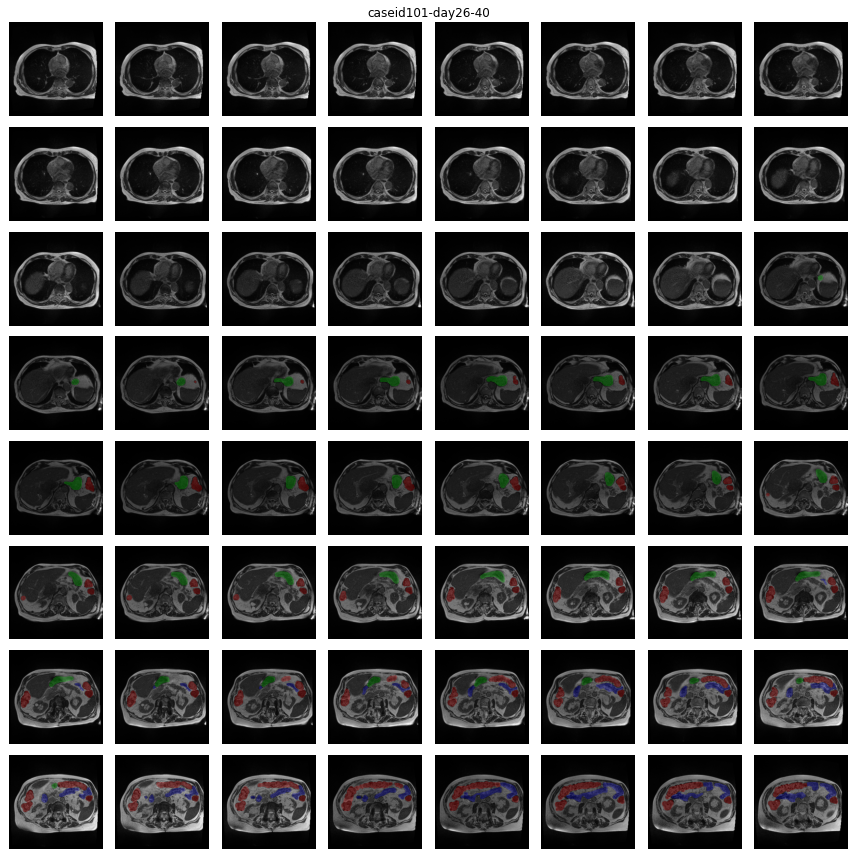

In [9]:
TEST_CASE_ID = 101
TEST_START_SLICE = 40
TEST_DAY = None

random_panels(train_df, TEST_CASE_ID, day=TEST_DAY, start_slice=TEST_START_SLICE)

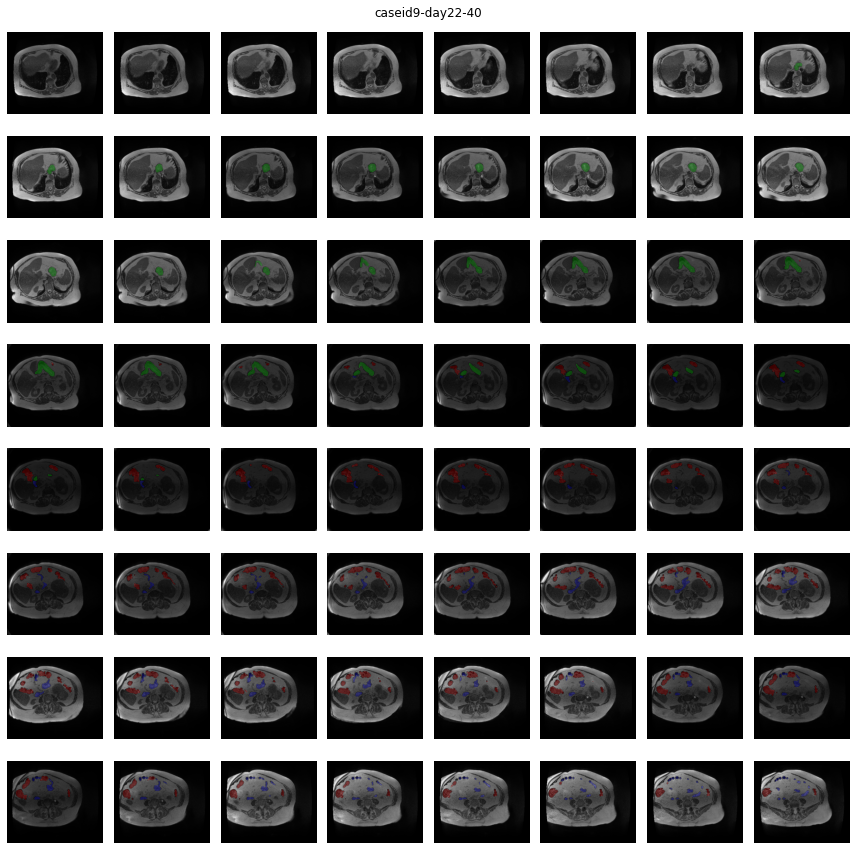

In [10]:
random_panels(train_df, 9, day=22, start_slice=TEST_START_SLICE)

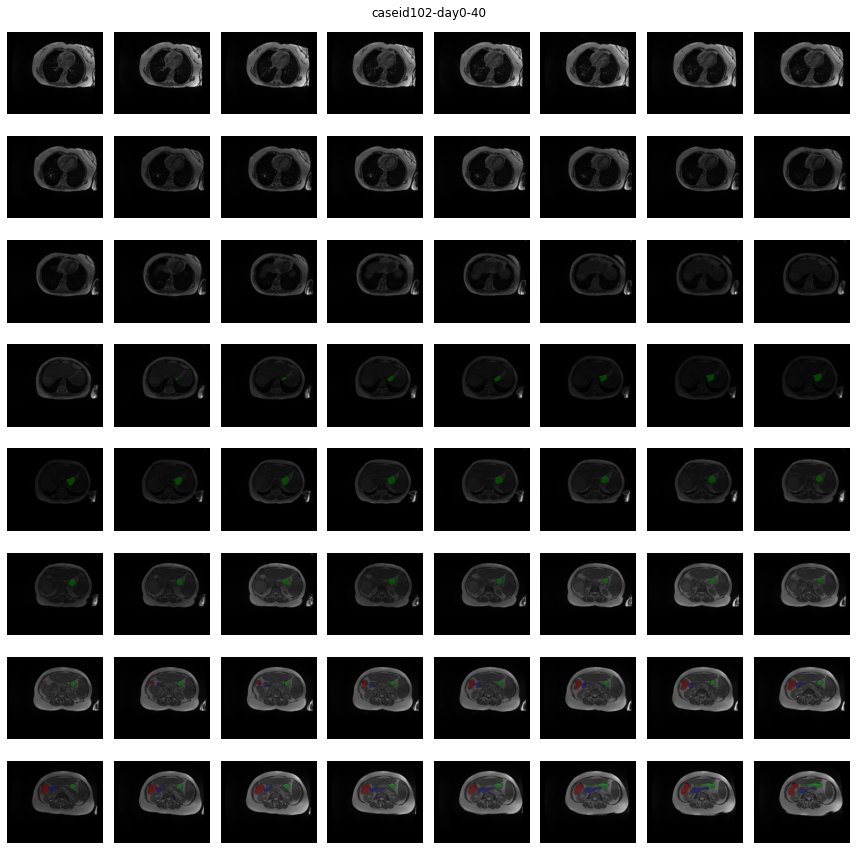

In [11]:
random_panels(train_df, 102, day=0, start_slice=TEST_START_SLICE)

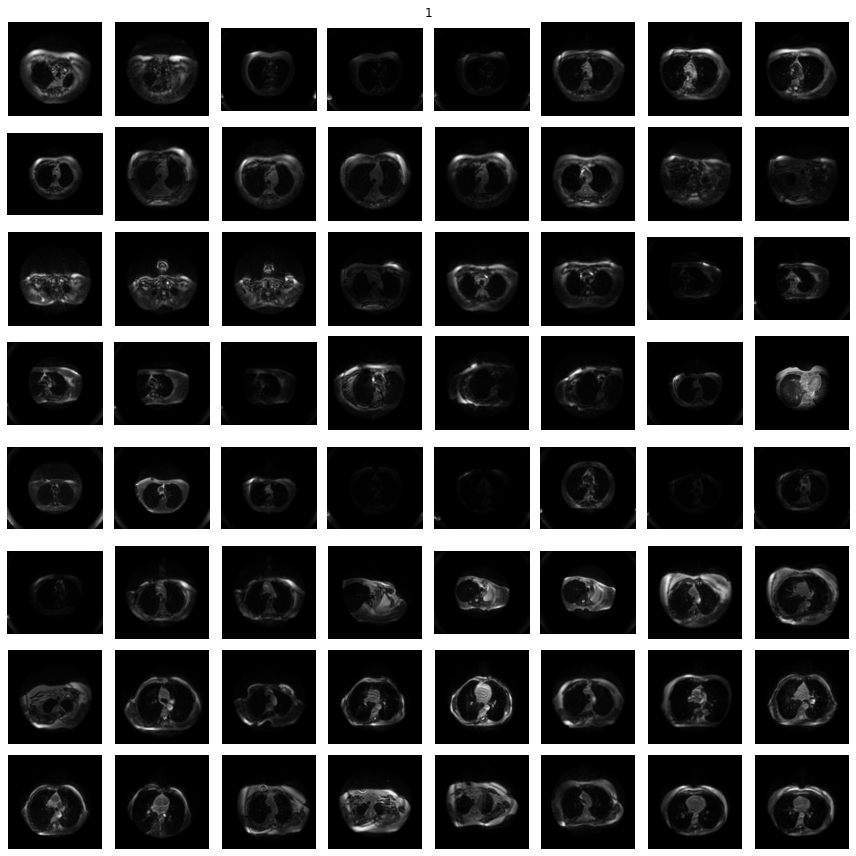

In [12]:
random_panels_same_slice(train_df, start_slice=1)

relative proportion of n_seg across images:
0: 0.56905
1: 0.06411
2: 0.28369
3: 0.08315


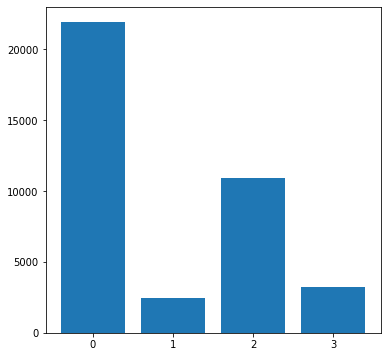

In [13]:
bar_target = 'n_seg'
bar_labels, bar_counts = np.unique(train_df[bar_target], return_counts=True)
sum_bar_counts = np.sum(bar_counts)

print(f"relative proportion of {bar_target} across images:")
for idx, i in enumerate(bar_labels):
    print(f"{i}: {bar_counts[idx]/sum_bar_counts:.5f}")
    
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)

ax1.bar(np.arange(len(bar_labels)), bar_counts)
ax1.set_xticks(np.arange(len(bar_labels)))
ax1.set_xticklabels(bar_labels)

plt.show()

relative proportion of height across images:
234: 0.00374
266: 0.67332
276: 0.03117
310: 0.29177


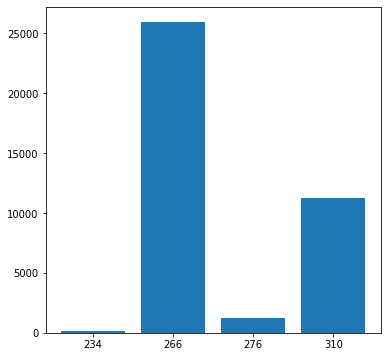

In [14]:
bar_target = 'height'
bar_labels, bar_counts = np.unique(train_df[bar_target], return_counts=True)
sum_bar_counts = np.sum(bar_counts)

print(f"relative proportion of {bar_target} across images:")
for idx, i in enumerate(bar_labels):
    print(f"{i}: {bar_counts[idx]/sum_bar_counts:.5f}")
    
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)

ax1.bar(np.arange(len(bar_labels)), bar_counts)
ax1.set_xticks(np.arange(len(bar_labels)))
ax1.set_xticklabels(bar_labels)

plt.show()

relative proportion of total_slices across images:
80: 0.03117
144: 0.96883


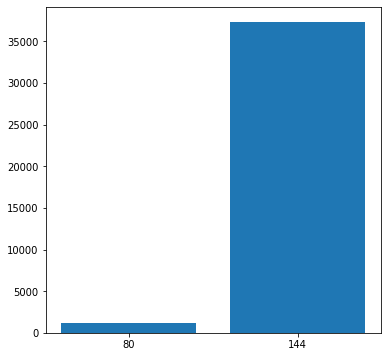

In [15]:
bar_target = 'total_slices'
bar_labels, bar_counts = np.unique(train_df[bar_target], return_counts=True)
sum_bar_counts = np.sum(bar_counts)

print(f"relative proportion of {bar_target} across images:")
for idx, i in enumerate(bar_labels):
    print(f"{i}: {bar_counts[idx]/sum_bar_counts:.5f}")

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)

ax1.bar(np.arange(len(bar_labels)), bar_counts)
ax1.set_xticks(np.arange(len(bar_labels)))
ax1.set_xticklabels(bar_labels)

plt.show()

In [16]:
"""
Data pipeline
"""
def dict_py_function(func, inp, Tout):
    """
    Trick py_function to take in a dict by passing our input off as an array, then reconstructing it inside a wrapped function
    Completely dumb.
    """
    def wrapped_func(*flattened_inp):
        #To reconstruct, pass tf.nest.pack_sequence_as(dict, flattened_dict_of_values, expand_composites=True)
        reconstructed_inp = tf.nest.pack_sequence_as(inp, flattened_inp, expand_composites=True)
        return func(*reconstructed_inp)
        
    return tf.py_function(func=wrapped_func, inp=tf.nest.flatten(inp, expand_composites=True), Tout=Tout)

def df_parser(row):
    """
    want to read file, process it, produce mask in multi-hot encoding
    img/mask output would be (size, 1)
    process image only once, include random_contrast here
    """  
    contrast = tf.random.truncated_normal([], 98, 0.25)
    
    img = process_img(row['fn'], contrast)
    mask = tf.zeros_like(img, dtype=tf.uint8)
    mask = tf.one_hot(tf.squeeze(mask), len(MASK_CLASS) + 1)
    mask_total = mask

    if row['n_seg'] == 0:
        return img, mask_total
    else:
        for class_ in MASK_CLASS:
            if row[class_] == 'nan':
                mask_total += mask
            else:
                mask_total += tf.one_hot(tf.constant(rle_decode(row[class_].numpy(), (row['height'], row['width'])) * MASK_ENCODE[class_], dtype=tf.uint8), len(MASK_CLASS) + 1)
        
        #reduce the background layer, subtract by class_num and clip by value. pixels where background = 4 implies there are no classes above it
        mask_total_base = tf.clip_by_value(mask_total[:,:,0] - len(MASK_CLASS), 0, 1)[:,:,tf.newaxis]
        mask_total = tf.concat([mask_total_base, mask_total[:,:,1:]], axis=-1)
        mask_total = tf.cast(mask_total, dtype=tf.float32)
                                         
        return img, mask_total
    
def construct_dataset(df):
    """
    split before construction. ensures reproducibility
    """
    train_dataset  = tf.data.Dataset.from_tensor_slices(df.to_dict('list')) 
    train_len = train_dataset.cardinality().numpy()
    
    #train_dataset = train_dataset.shuffle(train_len)
    #train_dataset = train_dataset.map(lambda a: dict_py_function(df_parser, [a], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    print(f"-- dataset sizes -- train:{train_len}")
                                     
    return train_dataset, train_len

In [17]:
kfold = StratifiedGroupKFold(15, shuffle=True, random_state=42)

split = kfold.split(train_df, train_df['n_seg'], groups=train_df['caseid'])

for i, (ve, te) in enumerate(kfold.split(train_df, train_df['n_seg'], groups=train_df['caseid'])):
    train_df.loc[te, 'fold'] = i

# for e in construct_dataset(train_df).batch(16).skip(5).take(1):
#     plot_dataset(e)

print(train_df.head())
print(train_df.groupby(['fold', 'n_seg'])['id'].count())

                         id  \
0  case101_day20_slice_0001   
1  case101_day20_slice_0002   
2  case101_day20_slice_0003   
3  case101_day20_slice_0004   
4  case101_day20_slice_0005   

                                                  fn  n_seg large_bowel  \
0  ./train/case101/case101_day20/scans/slice_0001...      0         nan   
1  ./train/case101/case101_day20/scans/slice_0002...      0         nan   
2  ./train/case101/case101_day20/scans/slice_0003...      0         nan   
3  ./train/case101/case101_day20/scans/slice_0004...      0         nan   
4  ./train/case101/case101_day20/scans/slice_0005...      0         nan   

  small_bowel stomach  height  width  h_spacing  w_spacing  caseid    day  \
0         nan     nan     266    266        1.5        1.5     101  day20   
1         nan     nan     266    266        1.5        1.5     101  day20   
2         nan     nan     266    266        1.5        1.5     101  day20   
3         nan     nan     266    266        1.5       

In [18]:
np.isin(train_df[train_df['fold'] == 1]['caseid'].unique(), train_df[~(train_df['fold'] == 1)]['caseid'].unique())

array([False, False, False, False, False])

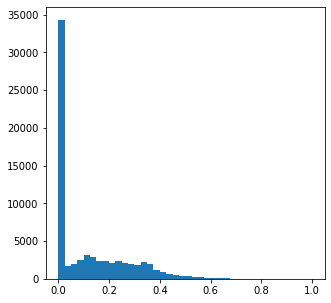

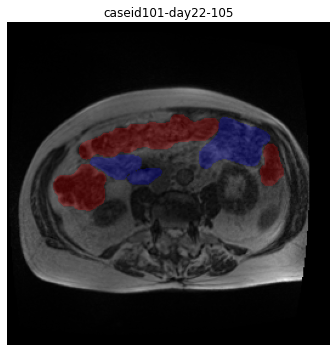

In [19]:
single_panel(train_df, TEST_CASE_ID, 22, 105)

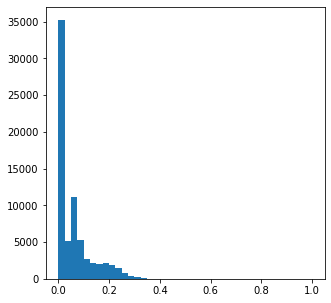

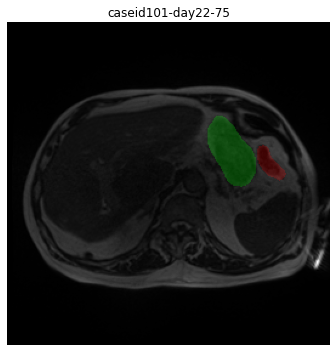

In [20]:
single_panel(train_df, TEST_CASE_ID, 22, 75)

In [21]:
train_df[train_df['slicenum'] == 1]

,id,fn,n_seg,large_bowel,small_bowel,stomach,height,width,h_spacing,w_spacing,caseid,day,total_slices,slicenum,fold
0,case101_day20_slice_0001,./train/case101/case101_day20/scans/slice_0001...,0,nan,nan,nan,266,266,1.5,1.5,101,day20,144,1,2.0
144,case101_day22_slice_0001,./train/case101/case101_day22/scans/slice_0001...,0,nan,nan,nan,266,266,1.5,1.5,101,day22,144,1,2.0
288,case101_day26_slice_0001,./train/case101/case101_day26/scans/slice_0001...,0,nan,nan,nan,266,266,1.5,1.5,101,day26,144,1,2.0
432,case101_day32_slice_0001,./train/case101/case101_day32/scans/slice_0001...,0,nan,nan,nan,266,266,1.5,1.5,101,day32,144,1,2.0
576,case102_day0_slice_0001,./train/case102/case102_day0/scans/slice_0001_...,0,nan,nan,nan,310,360,1.5,1.5,102,day0,144,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37776,case91_day0_slice_0001,./train/case91/case91_day0/scans/slice_0001_26...,0,nan,nan,nan,266,266,1.5,1.5,91,day0,144,1,0.0
37920,case92_day0_slice_0001,./train/case92/case92_day0/scans/slice_0001_26...,0,nan,nan,nan,266,266,1.5,1.5,92,day0,144,1,7.0
38064,case9_day0_slice_0001,./train/case9/case9_day0/scans/slice_0001_360_...,0,nan,nan,nan,310,360,1.5,1.5,9,day0,144,1,11.0
38208,case9_day20_slice_0001,./train/case9/case9_day20/scans/slice_0001_360...,0,nan,nan,nan,310,360,1.5,1.5,9,day20,144,1,11.0


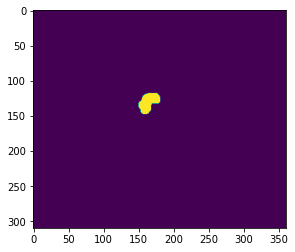

In [22]:
plt.imshow(rle_decode(train_df[(train_df['id'].str.contains('case9_day22')) & (train_df['n_seg'] > 0)].iloc[0]['stomach'], (310, 360)))

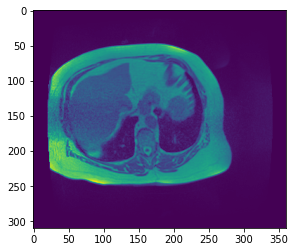

In [23]:
plt.imshow(process_img(train_df[(train_df['id'].str.contains('case9_day22')) & (train_df['n_seg'] > 0)].iloc[0]['fn']))

In [24]:
#DEFINE MODEL
from tensorflow.keras.layers import *

def conv_block(input_tensor, n_filters, kernel_size, strides=(1,1), activation='relu', padding='same', kernel_initializer='he_normal'):
    x = Conv2D(n_filters, kernel_size, strides=strides, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(input_tensor)
    x = BatchNormalization()(x)
    
    return x

def layer_down(input_tensor, n_filters, kernel_size=(3,3)):
    conv = conv_block(input_tensor, n_filters, kernel_size)
    conv = Dropout(0.2)(conv)
    conv = conv_block(conv, n_filters, kernel_size)
    pool = MaxPooling2D((2,2))(conv)
    
    return conv, pool

def layer_up(input_tensor, concat_tensor, n_filters, kernel_size=(3,3)):
    decv = concatenate([Conv2DTranspose(n_filters, kernel_size, strides=(2,2), padding='same')(input_tensor), concat_tensor])
    decv = conv_block(decv, n_filters, kernel_size)
    decv = Dropout(0.2)(decv)
    decv = conv_block(decv, n_filters, kernel_size)
    
    return decv

def u_net(input_size=(272, 272, 1), n_output=4, n_base=16):
    img_input = Input(input_size)
    
    c1, d1 = layer_down(img_input, n_base)
    c2, d2 = layer_down(d1, n_base*2)
    c3, d3 = layer_down(d2, n_base*4)
    c4, d4 = layer_down(d3, n_base*8)
    
    c5 = conv_block(d4, n_base*16, kernel_size=(3,3))
    
    u4 = layer_up(c5, c4, n_base*8)
    u3 = layer_up(u4, c3, n_base*4)
    u2 = layer_up(u3, c2, n_base*2)
    u1 = layer_up(u2, c1, n_base)
    
    out = Conv2D(n_output, (1,1), padding='same', activation='sigmoid')(u1)
    
    model = tf.keras.Model(inputs=[img_input], outputs=[out])
    
    return model

In [25]:
#MRESUNET
from tensorflow.keras.layers import *

def conv_block(input_tensor, n_filters, kernel_size, strides=(1,1), activation='relu', padding='same', kernel_initializer="he_normal"):
    x = Conv2D(n_filters, kernel_size, strides=strides, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(input_tensor)
    x = BatchNormalization()(x)
    return x

def MultiResBlock(n_filters, input_tensor, alpha = 1.67, dropout=None):
    
    W = alpha * n_filters
    shortcut = input_tensor

    shortcut = conv_block(shortcut, int(W*0.167) + int(W*0.333) +
                          int(W*0.5), (1, 1), activation=None, padding='same')

    conv3x3 = conv_block(input_tensor, int(W*0.167), (3, 3),
                         activation='relu', padding='same')

    conv5x5 = conv_block(conv3x3, int(W*0.333), (3, 3),
                         activation='relu', padding='same')

    conv7x7 = conv_block(conv5x5, int(W*0.5), (3, 3),
                         activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    if dropout: out = Dropout(dropout)(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(n_filters, length, input_tensor):
    shortcut = input_tensor
    shortcut = conv_block(shortcut, n_filters, (1, 1),
                         activation=None, padding='same')

    out = conv_block(input_tensor, n_filters, (3, 3), activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv_block(shortcut, n_filters, (1, 1),
                              activation=None, padding='same')

        out = conv_block(out, n_filters, (3, 3), activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out

def Reslayer_down(input_tensor, n_filters, length, dropout=None):
    conv = MultiResBlock(n_filters, input_tensor, dropout=None)
    pool = MaxPooling2D((2,2))(conv)
    if dropout: pool = Dropout(dropout)(pool)
    conv = ResPath(n_filters, length, input_tensor)

    return conv, pool

def Reslayer_up(input_tensor, concat_tensor, n_filters, dropout=None):
    decv = concatenate([Conv2DTranspose(n_filters, (2,2), strides=(2,2), padding='same')(input_tensor), concat_tensor])
    decv = MultiResBlock(n_filters, decv, dropout=dropout)

    return decv


def mRES_net(input_size=(128,128,3), n_output=1, n_base=24, dropout=None, pretrained_weights=None):
    """
    MultiRes UNet: https://arxiv.org/abs/1902.04049
    """
    img_input = Input(input_size)

    c1, d1 = Reslayer_down(img_input, n_base, 5)
    c2, d2 = Reslayer_down(d1, n_base*2,  4, dropout=dropout)
    c3, d3 = Reslayer_down(d2, n_base*4,  3)
    c4, d4 = Reslayer_down(d3, n_base*8,  2, dropout=dropout)
    c5, d5 = Reslayer_down(d4, n_base*16, 1)

    c6 = MultiResBlock(n_base*32, d5)

    u5 = Reslayer_up(c6, c5, n_base*16)
    u4 = Reslayer_up(u5, c4, n_base*8, dropout=dropout)
    u3 = Reslayer_up(u4, c3, n_base*4)
    u2 = Reslayer_up(u3, c2, n_base*2, dropout=dropout)
    u1 = Reslayer_up(u2, c1, n_base)

    out = Conv2D(n_output, (1, 1) , padding='same',activation='sigmoid')(u1)

    model = tf.keras.Model(inputs=[img_input], outputs=[out])

    if(pretrained_weights):
       model.load_weights(pretrained_weights)

    return model

In [26]:
#dice loss here, 1-dice_coef

#hybrid loss?

#mresunet

#2.5d net

#resnetv2

import segmentation_models as sm
from segmentation_models.base import functional as F

kwargs = {}
kwargs["backend"] = K

def weighted_cce(y_true, y_pred):

    #weights = np.array([1,1.6,5,5])    #class weights here

    #weights = np.array([1,5,5,2.5,2,1,1])  #3
    weights = np.array([1,10,10,10])

    weights = weights.reshape((1,1,1,4))
    kWeights = K.constant(weights)

    yWeights = kWeights * y_true         #shape (batch, n, m, class_labels)
    yWeights = K.sum(yWeights, axis=-1)  #shape (batch, n, m), each pixel is 'weighed' if they match

    loss = K.categorical_crossentropy(y_true, y_pred) #shape (batch, n, m), unweighed cc at each pixel
    wLoss = yWeights * loss

    return wLoss

def bce_weighted_cce(y_true, y_pred):
    
    return 0.5*weighted_cce(y_true, y_pred) + 0.5*sm.losses.dice_loss(y_true, y_pred)

def dice_coef(y_true, y_pred):
    """Dice coefficient"""
    dice = F.f_score(
        y_true,
        y_pred,
        beta=1,
        smooth=1e-5,
        per_image=False,
        threshold=0.5,
        **kwargs,
    )
    return dice


custom_objs = {
    'dice_coef': dice_coef,
    'f1-score': sm.metrics.FScore,
    "precision": sm.metrics.precision,
    "recall": sm.metrics.recall,
}

tf.keras.utils.get_custom_objects().update(custom_objs)


opt = tf.keras.optimizers.experimental.AdamW(epsilon=1e-2)


#model = u_net(input_size=(288,288,1))
#model.compile(loss=tf.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

model = mRES_net(input_size=IMG_SIZE + (1,), n_output=3)

model.compile(loss=bce_weighted_cce, optimizer='adam', metrics=[dice_coef,'precision', 'recall', 'f1-score'])

model.summary()

Segmentation Models: using `keras` framework.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 6)  60          ['input_1[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 128, 128, 6)  24         ['conv2d_1[0][0]']               
 rmalization)                                                                                     
                                                

                                                                                                  
 conv2d_27 (Conv2D)             (None, 32, 32, 26)   18512       ['max_pooling2d_1[0][0]']        
                                                                                                  
 batch_normalization_40 (BatchN  (None, 32, 32, 26)  104         ['conv2d_27[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_28 (Conv2D)             (None, 32, 32, 53)   12455       ['batch_normalization_40[0][0]'] 
                                                                                                  
 batch_normalization_41 (BatchN  (None, 32, 32, 53)  212         ['conv2d_28[0][0]']              
 ormalization)                                                                                    
          

 ormalization)                                                                                    
                                                                                                  
 conv2d_47 (Conv2D)             (None, 8, 8, 320)    613760      ['batch_normalization_68[0][0]'] 
                                                                                                  
 batch_normalization_69 (BatchN  (None, 8, 8, 320)   1280        ['conv2d_47[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_44 (Conv2D)             (None, 8, 8, 640)    204800      ['max_pooling2d_3[0][0]']        
                                                                                                  
 concatenate_4 (Concatenate)    (None, 8, 8, 640)    0           ['batch_normalization_67[0][0]', 
          

 ormalization)                                                                                    
                                                                                                  
 concatenate_6 (Concatenate)    (None, 8, 8, 768)    0           ['conv2d_transpose[0][0]',       
                                                                  'batch_normalization_74[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 8, 8, 107)    739691      ['concatenate_6[0][0]']          
                                                                                                  
 batch_normalization_82 (BatchN  (None, 8, 8, 107)   428         ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_56

 batch_normalization_45 (BatchN  (None, 32, 32, 96)  384         ['conv2d_30[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_46 (BatchN  (None, 32, 32, 96)  384         ['conv2d_31[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 concatenate_8 (Concatenate)    (None, 16, 16, 384)  0           ['conv2d_transpose_1[0][0]',     
                                                                  'batch_normalization_65[0][0]'] 
                                                                                                  
 add_12 (Add)                   (None, 32, 32, 96)   0           ['batch_normalization_45[0][0]', 
          

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_52 (BatchN  (None, 32, 32, 96)  384         ['conv2d_35[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_7 (Activation)      (None, 64, 64, 48)   0           ['add_7[0][0]']                  
                                                                                                  
 activation_22 (Activation)     (None, 16, 16, 319)  0           ['add_22[0][0]']                 
                                                                                                  
 add_14 (Add)                   (None, 32, 32, 96)   0           ['batch_normalization_51[0][0]', 
          

                                )                                                                 
                                                                                                  
 conv2d_65 (Conv2D)             (None, 32, 32, 80)   38240       ['batch_normalization_95[0][0]'] 
                                                                                                  
 add_9 (Add)                    (None, 64, 64, 48)   0           ['batch_normalization_33[0][0]', 
                                                                  'batch_normalization_34[0][0]'] 
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 128, 128, 24  96         ['activation_1[0][0]']           
 rmalization)                   )                                                                 
                                                                                                  
 batch_nor

 batch_normalization_38 (BatchN  (None, 64, 64, 48)  192         ['activation_10[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_12 (BatchN  (None, 128, 128, 24  96         ['conv2d_8[0][0]']               
 ormalization)                  )                                                                 
                                                                                                  
 batch_normalization_13 (BatchN  (None, 128, 128, 24  96         ['conv2d_9[0][0]']               
 ormalization)                  )                                                                 
                                                                                                  
 concatenate_12 (Concatenate)   (None, 64, 64, 96)   0           ['conv2d_transpose_3[0][0]',     
          

                                                                                                  
 activation_24 (Activation)     (None, 64, 64, 79)   0           ['add_24[0][0]']                 
                                                                                                  
 add_5 (Add)                    (None, 128, 128, 24  0           ['batch_normalization_18[0][0]', 
                                )                                 'batch_normalization_19[0][0]'] 
                                                                                                  
 batch_normalization_104 (Batch  (None, 64, 64, 79)  316         ['activation_24[0][0]']          
 Normalization)                                                                                   
                                                                                                  
 activation_5 (Activation)      (None, 128, 128, 24  0           ['add_5[0][0]']                  
          

In [26]:
print(len(train_df))
print(len(train_df[~(train_df['fold'].isin([0,1,2]))]))
print(len(train_df[(train_df['fold'].isin([0,1]))]))
print(len(train_df[(train_df['fold'].isin([2]))]))

38496
32160
3744
2592


In [27]:
"""
cleanest order should be, shift, zoom, rotate, fix
"""


train_ds, train_len = construct_dataset(train_df[~(train_df['fold'].isin([0,1,2]))])
val_ds, val_len = construct_dataset(train_df[(train_df['fold'].isin([0,1]))])
#test_ds = construct_dataset(train_df[(train_df['fold'].isin([2]))])

EPOCHS = 100
BATCH_SIZE = 16
STEPS_PER_EPOCH = train_len // BATCH_SIZE

train_ds = train_ds.shuffle(train_len).cache().prefetch(buffer_size=tf.data.AUTOTUNE) \
                   .map(lambda a: dict_py_function(df_parser, [a], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                   .map(lambda x1, y1: tf.py_function(random_shift, [x1, y1, 0.75], [tf.float32, tf.float32])) \
                   .map(lambda x2, y2: tf.py_function(random_zoom, [x2, y2, 0.75], [tf.float32, tf.float32])) \
                   .map(random_rotate) \
                   .map(random_colour) \
                   .map(random_flip) \
                   .map(fixup_shape) \
                   .batch(BATCH_SIZE)

val_ds = val_ds.map(lambda a: dict_py_function(df_parser, [a], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE) \
               .map(fixup_shape).batch(BATCH_SIZE)

-- dataset sizes -- train:32160
-- dataset sizes -- train:3744


(16, 128, 128, 4)


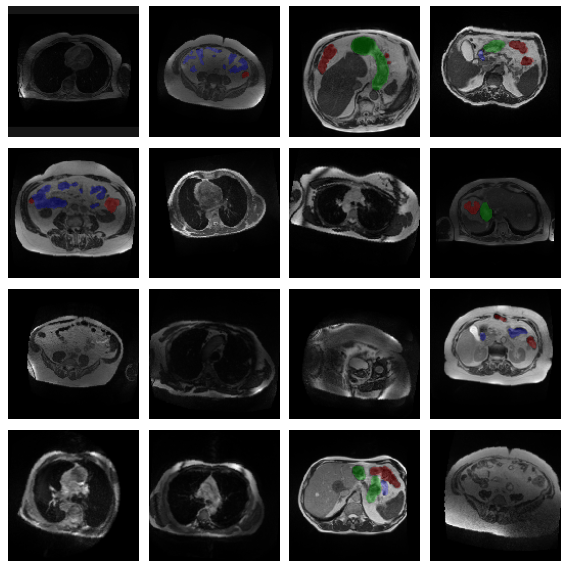

2022-07-05 15:01:16.674726: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [29]:
for e in train_ds.skip(10).take(1):
#for e in val_ds.map(lambda x1, y1: (tfa.image.translate(x1, [50, 50]), tfa.image.translate(y1, [50, 50]))).take(1):
#for e in val_ds.take(1):
    #print(e[0].shape, tf.math.reduce_variance(tf.cast(e[0][0,:100,:,0] == 0, dtype=tf.float32), axis=1))
    print(e[1].shape)
    plot_dataset(e)
    

In [29]:
MODEL_PREFIX = 'mresnet_augment'

earlystopping = callbacks.EarlyStopping(monitor='val_loss', verbose=1, min_delta=1e-4, patience=5)

plateau = callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6, verbose=1)

checkpoint = callbacks.ModelCheckpoint(
    f'./checkpoints/{MODEL_PREFIX}_checkpoint.hdf5',
    monitor="val_dice_coef",
    mode="max",
    verbose=1,
    save_best_only=True)
csv_logger = callbacks.CSVLogger(f'./{MODEL_PREFIX}_log.out', separator=',')

callback_list = [earlystopping, plateau, checkpoint, csv_logger]

In [ ]:
model_history = model.fit(train_ds, epochs=EPOCHS,
                         steps_per_epoch=STEPS_PER_EPOCH, validation_data=val_ds, callbacks=callback_list)

Epoch 1/100


2022-07-05 01:05:03.111026: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-07-05 01:05:04.753950: W tensorflow/core/common_runtime/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


2010/2010 [==============================] - ETA: 0s - loss: 0.4185 - dice_coef: 0.4964 - precision: 0.3917 - recall: 0.7430 - f1-score: 0.4293
Epoch 1: val_dice_coef improved from -inf to 0.76167, saving model to ./checkpoints/mresnet_augment_checkpoint.hdf5
2010/2010 [==============================] - 654s 320ms/step - loss: 0.4185 - dice_coef: 0.4964 - precision: 0.3917 - recall: 0.7430 - f1-score: 0.4293 - val_loss: 0.3860 - val_dice_coef: 0.7617 - val_precision: 0.4089 - val_recall: 0.8451 - val_f1-score: 0.3910 - lr: 0.0010
Epoch 2/100
2010/2010 [==============================] - ETA: 0s - loss: 0.2158 - dice_coef: 0.7247 - precision: 0.6870 - recall: 0.7499 - f1-score: 0.6993
Epoch 2: val_dice_coef improved from 0.76167 to 0.79568, saving model to ./checkpoints/mresnet_augment_checkpoint.hdf5
2010/2010 [==============================] - 646s 321ms/step - loss: 0.2158 - dice_coef: 0.7247 - precision: 0.6870 - recall: 0.7499 - f1-score: 0.6993 - val_loss: 0.3748 - val_dice_coef: 0

In [32]:
# tf.keras.backend.clear_session()

for key in model_history.history:
    print(key)

loss
precision
recall
f1-score
val_loss
val_precision
val_recall
val_f1-score
lr


In [ ]:
model.save(f'./models/model_{MODEL_PREFIX}.hdf5')

In [ ]:
val_ds = construct_dataset(train_df1[(train_df1['n_seg'] == 3)])

for e in val_ds.batch(1).take(1):
    test_elem = e
    
weights = np.array([1.,1.,1.,1.])
weights = tf.constant(weights.reshape((1,1,1,4)))
weights = tf.cast(weights, dtype=tf.float32)


In [ ]:
np.sum((test_elem[1] * weights).numpy())

In [ ]:
np.sum(tf.losses.categorical_crossentropy(test_elem[1] * weights, test_elem[1]+0.01).numpy())

In [ ]:
y_true = [[0, 1, 0], [0, 0, 1]]
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
loss = tf.losses.categorical_crossentropy(y_true, y_pred)
print(loss, tf.math.reduce_mean(loss * tf.constant([1.,1.])))

In [ ]:
tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred, sample_weight=tf.constant([1,5]))

In [ ]:
def cross_E(y_true, y_pred):                 # CE
    return -np.sum(y_true * np.log(y_pred + 10**-100))/2

cross_E(y_true, np.array(y_pred))

In [ ]:
(360 * tf.random.uniform([], 0.975, 1.025))//1

In [ ]:
test_img = process_img(train_df[(train_df['id'].str.contains('case9_day22')) & (train_df['n_seg'] > 0)].iloc[0]['fn'])[np.newaxis,...]

In [ ]:
print(test_img.shape)
plt.imshow(test_img[0,...])

In [ ]:
plt.imshow(random_shift(test_img, test_img)[0][0,...])

In [ ]:
print(tf.math.reduce_sum(tf.cast(test_img[0,:50,:,0] < 0.1, dtype=tf.float32)))
print(tf.math.reduce_sum(tf.cast(test_img[0,-50:,:,0] < 0.1, dtype=tf.float32)))

print(tf.math.reduce_sum(tf.cast(test_img[0,:,:50,0] < 0.1, dtype=tf.float32)))
print(tf.math.reduce_sum(tf.cast(test_img[0,:,-50:,0] < 0.1, dtype=tf.float32)))


In [ ]:
def random_shift(img, label):
    """
    random translation of image, towards the center (more black pixels).
    """
    thresh = 0.1
    h, w = img.shape[1], img.shape[2]
    div = 3
    
    top_row = tf.math.reduce_sum(tf.cast(img[0,:h//div,:,0] < 0.1, dtype=tf.float32))
    bottom_row = tf.math.reduce_sum(tf.cast(img[0,-h//div:,:,0] < 0.1, dtype=tf.float32))
    
    left_col = tf.math.reduce_sum(tf.cast(img[0,:,:w//div,0] < 0.1, dtype=tf.float32))
    right_col = tf.math.reduce_sum(tf.cast(img[0,:,-w//div:,0] < 0.1, dtype=tf.float32))
    
    print(top_row, bottom_row, '..', left_col, right_col)
    
    if top_row/bottom_row > 1 - thresh and top_row/bottom_row < 1 + thresh:
        y_dir = 0
    elif top_row/bottom_row < 1 - thresh:
        y_dir = 1
    else:
        y_dir = -1
        
    if left_col/right_col > 1 - thresh and left_col/right_col < 1 + thresh:
        x_dir = 0
    elif left_col/right_col < 1 - thresh:
        x_dir = 1
    else:
        x_dir = -1
        
    print(x_dir, y_dir)
    
    
    h = tf.cast(y_dir * h * tf.random.uniform([], 0.0, 0.12), dtype=tf.int32)
    w = tf.cast(x_dir * w * tf.random.uniform([], 0.0, 0.12), dtype=tf.int32)
        
    return tfa.image.translate(img, [w, h]), tfa.image.translate(label, [w, h])

In [ ]:
res50 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')

In [ ]:
res50_model = tf.keras.Model(inputs=[Input((None, 256,256,3))], outputs=[res50.output], name='res50nn')

In [ ]:
res50.input